In [264]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
from scipy import stats
from datetime import datetime
from utils.traveling import calculate_distance

### Read Data

In [211]:
drivers_df = pd.read_excel('../data/drivers.xlsx')
riders_df = pd.read_excel('../data/riders.xlsx')

In [83]:
def convert_time_to_float(time_series):
    # Convert to datetime objects
    deltas = time_series.diff().dt.total_seconds().dropna().tolist()
    deltas = np.array(deltas)/60
    return deltas

In [167]:
def mle_params(series, dist_name):
    if dist_name == 'exponential':
        dist = stats.expon
    elif dist_name == 'uniform':
        dist = stats.uniform
    else:
        raise ValueError(f"Unsupported distribution: {dist_name}")
    return dist.fit(series, floc=0)

In [168]:
def ks_test(series, dist_name, params):
    """
    Performs the Kolmogorov-Smirnov (KS) test while correctly passing estimated parameters
    to the cumulative distribution function (CDF), including degrees of freedom adjustments.

    :param series: Numeric data series (e.g., time deltas).
    :param dist_name: Name of the distribution ('exponential', 'uniform', etc.).
    :return: KS statistic and p-value.
    """
    if dist_name == 'exponential':
        dist = stats.expon
    elif dist_name == 'uniform':
        dist = stats.uniform
    else:
        raise ValueError(f"Unsupported distribution: {dist_name}")

    n = len(series)
    # Perform KS test and explicitly pass fitted parameters (including df adjustment)
    ks_stat, p_value = stats.kstest(series, dist.cdf, args=params, N=n)

    return ks_stat, p_value



In [150]:
deltas_drivers = convert_time_to_float(drivers_df['arrival_datetime'])
deltas_riders = convert_time_to_float(riders_df['request_datetime'])

(array([42., 50., 35., 30., 31., 30., 25., 17., 19., 16., 13.,  7.,  5.,
        11.,  9.,  6.,  3.,  6.,  4.,  0.,  0.,  0.,  5.,  1.,  2.,  4.,
         2.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.01550000e-01, 2.14590067e+00, 4.19025133e+00, 6.23460200e+00,
        8.27895267e+00, 1.03233033e+01, 1.23676540e+01, 1.44120047e+01,
        1.64563553e+01, 1.85007060e+01, 2.05450567e+01, 2.25894073e+01,
        2.46337580e+01, 2.66781087e+01, 2.87224593e+01, 3.07668100e+01,
        3.28111607e+01, 3.48555113e+01, 3.68998620e+01, 3.89442127e+01,
        4.09885633e+01, 4.30329140e+01, 4.50772647e+01, 4.71216153e+01,
        4.91659660e+01, 5.12103167e+01, 5.32546673e+01, 5.52990180e+01,
        5.73433687e+01, 5.93877193e+01, 6.14320700e+01, 6.34764207e+01,
        6.55207713e+01, 6.75651220e+01, 6.96094727e+01, 7.16538233e+01,
        7.36981740e+01, 7.57425247e+01, 7.77868753e+01, 7.98312260e+

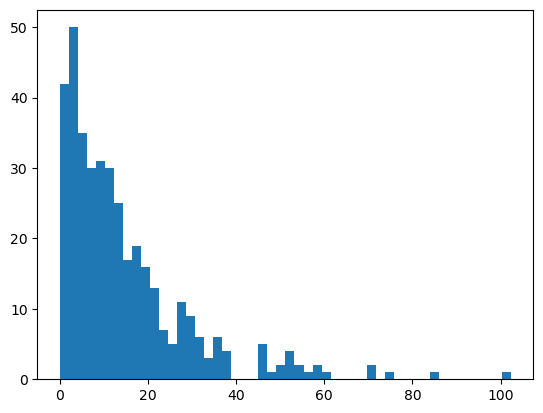

In [151]:
plt.hist(deltas_drivers, bins= 50)

(array([650., 467., 392., 328., 261., 186., 146., 126., 100.,  85.,  79.,
         46.,  36.,  20.,  20.,  24.,  21.,   9.,   5.,   8.,   4.,   4.,
          5.,   3.,   2.,   1.,   2.,   3.,   1.,   0.,   0.,   0.,   1.,
          0.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([6.16666667e-04, 4.35554333e-01, 8.70492000e-01, 1.30542967e+00,
        1.74036733e+00, 2.17530500e+00, 2.61024267e+00, 3.04518033e+00,
        3.48011800e+00, 3.91505567e+00, 4.34999333e+00, 4.78493100e+00,
        5.21986867e+00, 5.65480633e+00, 6.08974400e+00, 6.52468167e+00,
        6.95961933e+00, 7.39455700e+00, 7.82949467e+00, 8.26443233e+00,
        8.69937000e+00, 9.13430767e+00, 9.56924533e+00, 1.00041830e+01,
        1.04391207e+01, 1.08740583e+01, 1.13089960e+01, 1.17439337e+01,
        1.21788713e+01, 1.26138090e+01, 1.30487467e+01, 1.34836843e+01,
        1.39186220e+01, 1.43535597e+01, 1.47884973e+01, 1.52234350e+01,
        1.

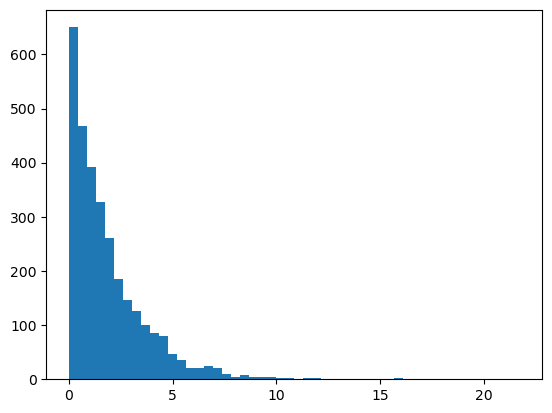

In [152]:
plt.hist(deltas_riders, bins= 50)

### Test Inter-Arrival

### Test using Given params

In [169]:
drivers_ks_test = ks_test(deltas_drivers, 'exponential', (0, 1/0.05))
drivers_ks_test

(0.13650147793000822, 1.1395508701405754e-06)

In [170]:
riders_ks_test = ks_test(deltas_riders, 'exponential', (0, 1/0.5))
riders_ks_test

(0.03015083109996064, 0.007804816052519704)

In [175]:
1 / mle_params(deltas_drivers, 'exponential')[1]

0.06818402519746007

In [174]:
1 / mle_params(deltas_riders, 'exponential')[1]

0.5335198676870729

### Driver jobs time

In [295]:
sample_jobs_time = (drivers_df['offline_datetime'] - drivers_df['arrival_datetime']).dt.total_seconds()
sample_jobs_time = np.array(sample_jobs_time) / 60
ks_test(sample_jobs_time, 'uniform', (300, 480))

(0.6280426736111111, 1.1525559366680103e-146)

In [291]:
sample_jobs_time.max()

478.53951666666666

In [290]:
sample_jobs_time.min()

360.5502666666667

(array([ 5.,  2.,  5., 10.,  4.,  4.,  8.,  7.,  8.,  6.,  2.,  4.,  3.,
         2.,  2.,  4.,  3.,  3.,  5.,  3.,  2.,  3.,  1.,  3.,  5.,  2.,
         4.,  2.,  5.,  4.,  8.,  4.,  0.,  2.,  3.,  1.,  5.,  2.,  3.,
         3.,  9.,  3.,  3.,  1.,  1.,  2.,  4.,  3.,  3.,  2.,  1.,  3.,
         2.,  5.,  2.,  4.,  1.,  6.,  6.,  4.,  3.,  5.,  5.,  3.,  5.,
         6.,  5.,  6.,  1.,  4.,  1.,  3.,  5.,  8.,  3.,  2.,  6.,  7.,
         6.,  2.,  3.,  3.,  4.,  3.,  2.,  4.,  7.,  3.,  2.,  2.,  6.,
         5.,  4.,  4.,  0.,  2.,  2., 12.,  7.,  5.]),
 array([360.55026667, 361.73015917, 362.91005167, 364.08994417,
        365.26983667, 366.44972917, 367.62962167, 368.80951417,
        369.98940667, 371.16929917, 372.34919167, 373.52908417,
        374.70897667, 375.88886917, 377.06876167, 378.24865417,
        379.42854667, 380.60843917, 381.78833167, 382.96822417,
        384.14811667, 385.32800917, 386.50790167, 387.68779417,
        388.86768667, 390.04757917, 391.22747167, 

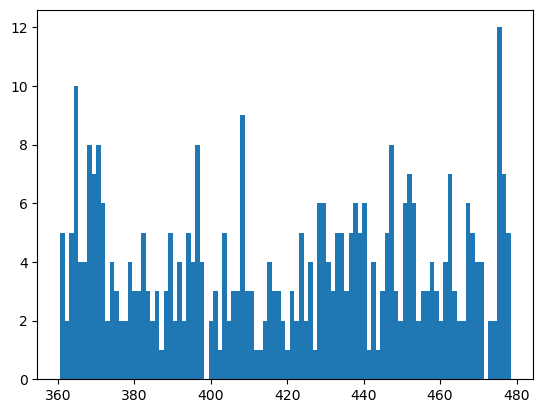

In [296]:
plt.hist(sample_jobs_time, bins=100)

#### Riders patience time

No values might be testable using status count (binomial test)

### Origins and Destination

#### Drivers, riders Origin, riders destination

In [212]:
drivers_df['initial_location'] = drivers_df['initial_location'].apply(lambda x: eval(x))
riders_df['pickup_location'] = riders_df['pickup_location'].apply(lambda x: eval(x))
riders_df['dropoff_location'] = riders_df['dropoff_location'].apply(lambda x: eval(x))

In [214]:
driver_origin_x = drivers_df['initial_location'].apply(lambda x: x[0])
driver_origin_y = drivers_df['initial_location'].apply(lambda x: x[1])
rider_origin_x = riders_df['pickup_location'].apply(lambda x: x[0])
rider_origin_y = riders_df['pickup_location'].apply(lambda x: x[1])
rider_dest_x = riders_df['dropoff_location'].apply(lambda x: x[0])
rider_dest_y = riders_df['dropoff_location'].apply(lambda x: x[1])

<Axes: >

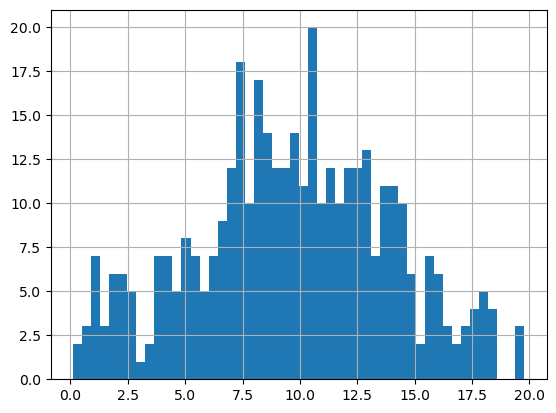

In [226]:
driver_origin_x.hist(bins=50)

<Axes: >

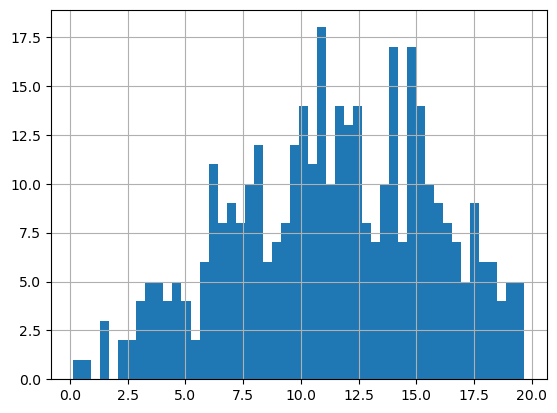

In [227]:
driver_origin_y.hist(bins=50)

<Axes: >

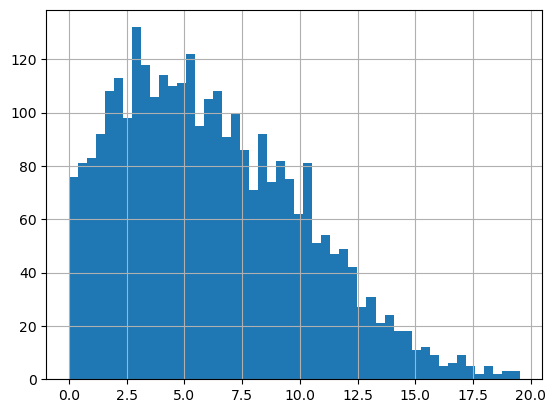

In [237]:
rider_origin_x.hist(bins=50)

<Axes: >

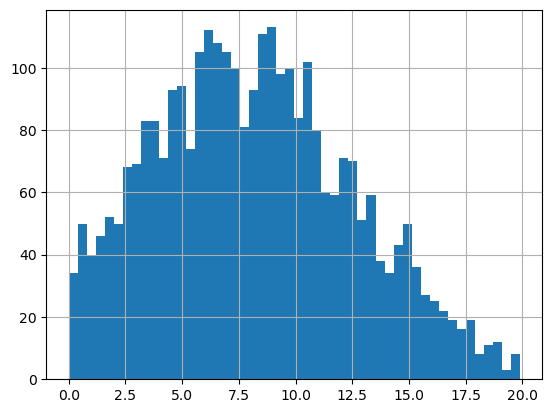

In [238]:
rider_origin_y.hist(bins=50)

<Axes: >

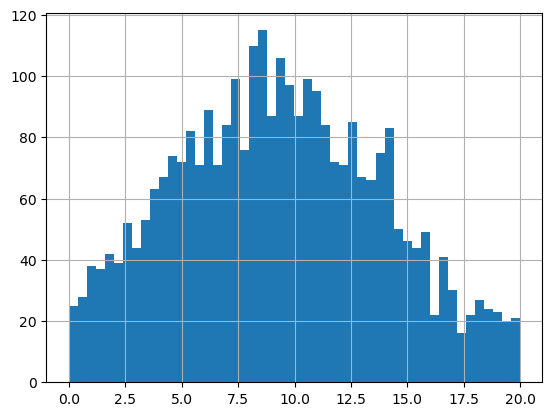

In [228]:
rider_dest_x.hist(bins=50)

<Axes: >

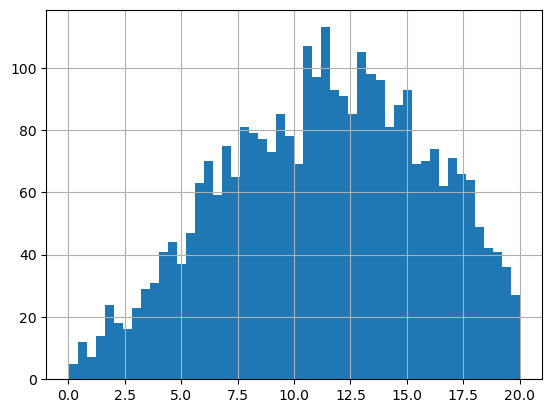

In [234]:
rider_dest_y.hist(bins=50)

#### suspiciously Gaussian

In [232]:
ks_test(driver_origin_x, 'uniform', (0, 20))

(0.15445515704023938, 1.913111142242514e-08)

In [245]:
ks_test(driver_origin_y, 'uniform', (0, 20))

(0.18940735696757516, 1.6636954793638068e-12)

In [244]:
ks_test(rider_origin_x, 'uniform', (0, 20))

(0.32450008498277694, 1.8960142616459827e-285)

In [250]:
ks_test(rider_origin_y, 'uniform', (0, 20))

(0.20654645766806135, 3.220341345129774e-114)

In [242]:
ks_test(rider_dest_x, 'uniform', (0, 20))

(0.13780035899024268, 8.134954839839249e-51)

In [243]:
ks_test(rider_dest_y, 'uniform', (0, 20))

(0.16744178714027674, 5.728045182799932e-75)

### Test Origins and Destination

In [270]:
sample_travel_time_series = (riders_df['dropoff_datetime'] - riders_df['pickup_datetime']).dt.total_seconds()
sample_travel_time = sample_travel_time_series[~ sample_travel_time_series.isna()]
sample_travel_time = np.array(sample_travel_time) / 60
sample_travel_time

array([20.83455   , 19.5621    , 24.35865   , ..., 58.10045   ,
       31.03663333, 27.64033333])

In [271]:
sample_dist = calculate_distance(rider_origin_x, rider_origin_y, rider_dest_x, rider_dest_y)[~ sample_travel_time_series.isna()]

In [273]:
sample_speed = sample_dist / sample_travel_time
sample_speed

0       0.344767
1       0.308847
3       0.374602
4       0.371420
5       0.393921
          ...   
3027    0.349933
3029    0.328338
3030    0.303897
3032    0.279918
3036    0.293838
Length: 2881, dtype: float64

(array([ 3.,  4.,  9., 10., 12., 13., 12., 15., 24., 27., 23., 32., 31.,
        50., 47., 46., 45., 39., 42., 53., 52., 54., 54., 60., 41., 49.,
        66., 44., 56., 52., 53., 48., 66., 55., 51., 44., 56., 50., 53.,
        63., 63., 56., 43., 54., 50., 51., 49., 57., 34., 42., 47., 41.,
        42., 42., 40., 34., 42., 35., 31., 37., 29., 26., 20., 23., 26.,
        21., 24., 20., 23., 15., 13., 16., 16., 14., 10.,  9., 10.,  7.,
        14.,  7.,  7.,  6.,  4.,  8.,  2.,  2.,  1.,  1.,  0.,  5.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.]),
 array([ 0.0991039 ,  0.326719  ,  0.55433411,  0.78194921,  1.00956431,
         1.23717941,  1.46479451,  1.69240961,  1.92002471,  2.14763981,
         2.37525491,  2.60287002,  2.83048512,  3.05810022,  3.28571532,
         3.51333042,  3.74094552,  3.96856062,  4.19617572,  4.42379082,
         4.65140593,  4.87902103,  5.10663613,  5.33425123,  5.56186633,
         5.78948143,  6.01709653,  6.24471163,  6.47232673,  6.699941

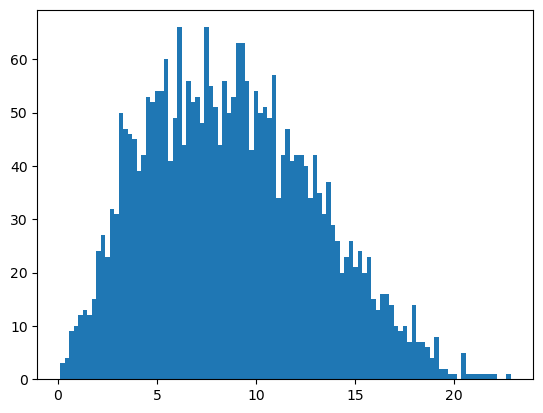

In [302]:
plt.hist(sample_dist, bins=100)

(array([ 3.,  5., 13.,  9., 18., 12., 14., 24., 19., 32., 40., 42., 51.,
        43., 51., 41., 54., 49., 65., 54., 65., 55., 62., 54., 41., 65.,
        55., 71., 55., 62., 59., 47., 59., 48., 64., 72., 48., 46., 58.,
        55., 50., 53., 62., 47., 50., 46., 54., 52., 36., 38., 38., 31.,
        41., 35., 24., 27., 35., 37., 18., 30., 22., 24., 25., 19., 21.,
        12., 11., 11., 17., 11., 16., 10.,  9., 14.,  8.,  7.,  9.,  7.,
         8.,  3.,  4.,  3.,  2.,  5.,  3.,  2.,  1.,  2.,  2.,  3.,  0.,
         0.,  2.,  0.,  0.,  2.,  0.,  0.,  1.,  1.]),
 array([ 0.31245 ,  1.044251,  1.776052,  2.507853,  3.239654,  3.971455,
         4.703256,  5.435057,  6.166858,  6.898659,  7.63046 ,  8.362261,
         9.094062,  9.825863, 10.557664, 11.289465, 12.021266, 12.753067,
        13.484868, 14.216669, 14.94847 , 15.680271, 16.412072, 17.143873,
        17.875674, 18.607475, 19.339276, 20.071077, 20.802878, 21.534679,
        22.26648 , 22.998281, 23.730082, 24.461883, 25.193684, 2

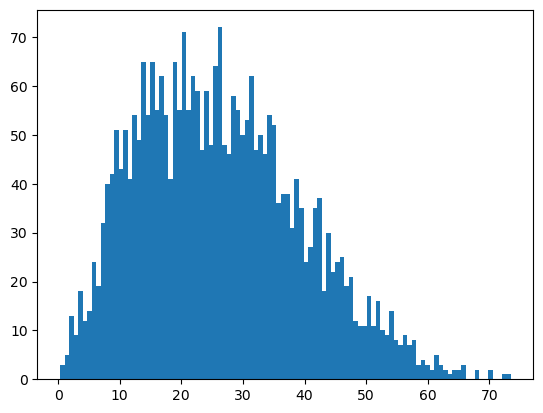

In [301]:
plt.hist(sample_travel_time, bins=100)

<Axes: >

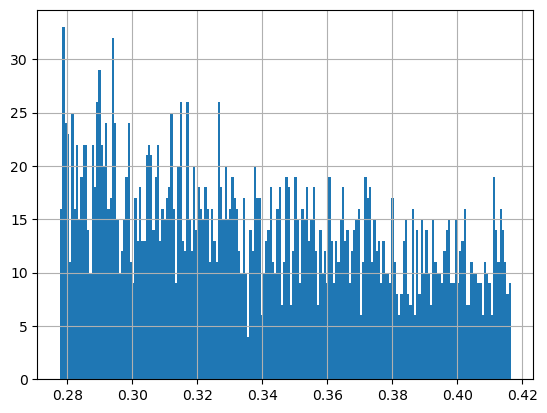

In [303]:
sample_speed.hist(bins=200)

In [287]:
ks_test(sample_speed, 'uniform', (((2/6) * 0.8), ((2/6) * 1.2)))

(0.6253361170526348, 0.0)

### CI 

In [142]:
def ks_confidence_interval(ks_stat, n, alpha=0.05):
    """
    Computes the confidence interval for the KS statistic.

    :param ks_stat: The KS test statistic.
    :param n: Sample size used in the KS test.
    :param alpha: Significance level (default: 0.05 for 95% CI).
    :return: (lower_bound, upper_bound) confidence interval for the KS statistic.
    """
    z_critical = stats.norm.ppf(1 - alpha / 2)  # 1.96 for 95% CI
    se = 1 / np.sqrt(n)  # Standard error approximation

    lower_bound = max(0, ks_stat - z_critical * se)  # Ensure CI is non-negative
    upper_bound = min(1, ks_stat + z_critical * se)  # KS statistic cannot exceed 1

    return lower_bound, upper_bound

In [148]:
drivers_ks_ci = ks_confidence_interval(drivers_ks_test[0], len(deltas_drivers))
drivers_ks_ci

(0.7869129954521543, 0.9874739579875695)

(array([650., 467., 392., 328., 261., 186., 146., 126., 100.,  85.,  79.,
         46.,  36.,  20.,  20.,  24.,  21.,   9.,   5.,   8.,   4.,   4.,
          5.,   3.,   2.,   1.,   2.,   3.,   1.,   0.,   0.,   0.,   1.,
          0.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([6.16666667e-04, 4.35554333e-01, 8.70492000e-01, 1.30542967e+00,
        1.74036733e+00, 2.17530500e+00, 2.61024267e+00, 3.04518033e+00,
        3.48011800e+00, 3.91505567e+00, 4.34999333e+00, 4.78493100e+00,
        5.21986867e+00, 5.65480633e+00, 6.08974400e+00, 6.52468167e+00,
        6.95961933e+00, 7.39455700e+00, 7.82949467e+00, 8.26443233e+00,
        8.69937000e+00, 9.13430767e+00, 9.56924533e+00, 1.00041830e+01,
        1.04391207e+01, 1.08740583e+01, 1.13089960e+01, 1.17439337e+01,
        1.21788713e+01, 1.26138090e+01, 1.30487467e+01, 1.34836843e+01,
        1.39186220e+01, 1.43535597e+01, 1.47884973e+01, 1.52234350e+01,
        1.

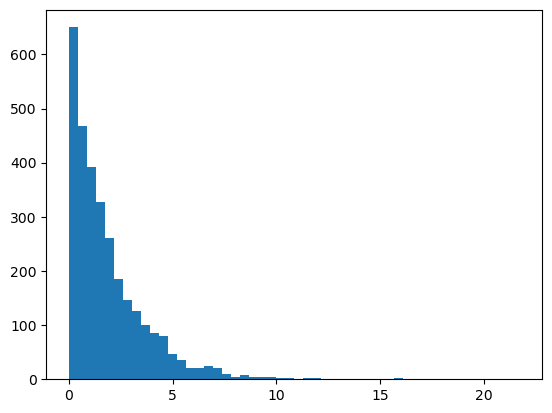

In [106]:
plt.hist(deltas_riders, bins= 50)

In [107]:
ks_test(deltas_drivers, 'exponential')

(0.10155, 14.56464192844677, 1)


TypeError: _parse_args() takes from 1 to 3 positional arguments but 4 were given

In [96]:
ks_test(deltas_riders, 'exponential')

(0.011155166548972001,
 0.8396713902462593,
 (0.0006166666666666666, 1.8737277777777774))

In [81]:
1 / estimates_params(deltas_drivers, 'exponential')[1]

0.06865942911008756

In [82]:
deltas_riders = convert_time_to_float(riders_df['request_datetime'])
1 / estimates_params(deltas_riders, 'exponential')[1]

0.5336954555831958

In [54]:
ks_test(deltas_drivers, '')

,id,pickup_location,dropoff_location,status,request_datetime,pickup_datetime,dropoff_datetime
0,1,"(2.447970933303984, 8.045456768809164)","(9.628029064263409, 8.253389565629009)",dropped-off,2025-01-01 13:03:02.081,2025-01-01 13:31:17.759,2025-01-01 13:52:07.832
1,2,"(4.475647451723581, 7.1964404336695615)","(1.211590816472369, 12.280530967768208)",dropped-off,2025-01-01 13:04:51.369,2025-01-01 13:51:00.847,2025-01-01 14:10:34.573
2,3,"(9.20470910820636, 0.7160055403558001)","(2.644199392649951, 5.2282261408887765)",abandoned,2025-01-01 13:05:26.008,NaT,NaT
3,4,"(10.331713748400134, 9.555321968516342)","(4.178168535907174, 16.29295664090579)",dropped-off,2025-01-01 13:05:36.654,2025-01-01 13:28:02.419,2025-01-01 13:52:23.938
4,5,"(8.946241716159276, 14.807761030483535)","(0.7096233854185741, 13.88396865866329)",dropped-off,2025-01-01 13:06:24.152,2025-01-01 13:28:23.701,2025-01-01 13:50:42.604
